# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=20,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-58-43/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4694 | MulticlassF1Score=0.1714
Batch-30 : CrossEntropyLoss=2.4849 | MulticlassF1Score=0.2121
Batch-45 : CrossEntropyLoss=2.4381 | MulticlassF1Score=0.2269
Batch-60 : CrossEntropyLoss=2.4534 | MulticlassF1Score=0.2338
Batch-75 : CrossEntropyLoss=2.4704 | MulticlassF1Score=0.2425
Batch-90 : CrossEntropyLoss=2.4924 | MulticlassF1Score=0.2589
Batch-105: CrossEntropyLoss=2.4462 | MulticlassF1Score=0.2750
Batch-120: CrossEntropyLoss=2.4407 | MulticlassF1Score=0.2871
Batch-135: CrossEntropyLoss=2.3936 | MulticlassF1Score=0.3027
Batch-150: CrossEntropyLoss=2.4111 | MulticlassF1Score=0.3205
Batch-165: CrossEntropyLoss=2.4263 | MulticlassF1Score=0.3351
Batch-180: CrossEntropyLoss=2.4077 | MulticlassF1Score=0.3482
Batch-195: CrossEntropyLoss=2.4122 | MulticlassF1Score=0.3592
Batch-210: CrossEntropyLoss=2.4025 | MulticlassF1Score=0.3683
Batch-225: CrossEntropyLoss=2.3792 | MulticlassF1Score=0.3810
Batch-226: CrossEntropyLoss=2.3806 | MulticlassF1Score=0.3815

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3840 | MulticlassF1Score=0.5636
Batch-30 : CrossEntropyLoss=2.3681 | MulticlassF1Score=0.5650
Batch-45 : CrossEntropyLoss=2.3933 | MulticlassF1Score=0.5626
Batch-60 : CrossEntropyLoss=2.3724 | MulticlassF1Score=0.5629
Batch-63 : CrossEntropyLoss=2.3612 | MulticlassF1Score=0.5628

Training   : Mean CrossEntropyLoss = 2.4497 | Mean MulticlassF1Score = 0.2797
Validation : Mean CrossEntropyLoss = 2.3839 | Mean MulticlassF1Score = 0.5629

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3565 | MulticlassF1Score=0.6006
Batch-30 : CrossEntropyLoss=2.3511 | MulticlassF1Score=0.6319
Batch-45 : CrossEntropyLoss=2.3506 | MulticlassF1Score=0.6438
Batch-60 : CrossEntropyLoss=2.3444 | MulticlassF1Score=0.6513
Batch-75 : CrossEntropyLoss=2.3398 | MulticlassF1Score=0.6564
Batch-90 : CrossEntropyLoss=2.3541 | MulticlassF1Score=0.6599
Batch-105: CrossEntropyLoss=2.3574 | MulticlassF1Score=0.6625
Batch-120: CrossEntropyLoss=2.3300 | MulticlassF1Score=0.6645
Batch-135: CrossEntropyLoss=2.3626 | MulticlassF1Score=0.6657
Batch-150: CrossEntropyLoss=2.3431 | MulticlassF1Score=0.6665
Batch-165: CrossEntropyLoss=2.3519 | MulticlassF1Score=0.6678
Batch-180: CrossEntropyLoss=2.3580 | MulticlassF1Score=0.6689
Batch-195: CrossEntropyLoss=2.3642 | MulticlassF1Score=0.6699
Batch-210: CrossEntropyLoss=2.3447 | MulticlassF1Score=0.6728
Batch-225: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.6764
Batch-226: CrossEntropyLoss=2.3302 | MulticlassF1Score=0.6766

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3522 | MulticlassF1Score=0.7292
Batch-30 : CrossEntropyLoss=2.3351 | MulticlassF1Score=0.7325
Batch-45 : CrossEntropyLoss=2.3365 | MulticlassF1Score=0.7339
Batch-60 : CrossEntropyLoss=2.3243 | MulticlassF1Score=0.7340
Batch-63 : CrossEntropyLoss=2.3380 | MulticlassF1Score=0.7347

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3489 | Mean MulticlassF1Score = 0.6530
Validation : Mean CrossEntropyLoss = 2.3296 | Mean MulticlassF1Score = 0.7322

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3244 | MulticlassF1Score=0.7681
Batch-30 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.7811
Batch-45 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.7918
Batch-60 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.7983
Batch-75 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8019
Batch-90 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8055
Batch-105: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8081
Batch-120: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8101
Batch-135: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8119
Batch-150: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8127
Batch-165: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8131
Batch-180: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8137
Batch-195: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8145
Batch-210: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8150
Batch-225: CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8154
Batch-226: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8155

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8216
Batch-30 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8191
Batch-45 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8204
Batch-60 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8203
Batch-63 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8194

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3057 | Mean MulticlassF1Score = 0.8018
Validation : Mean CrossEntropyLoss = 2.3038 | Mean MulticlassF1Score = 0.8208

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8252
Batch-30 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8258
Batch-45 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8266
Batch-60 : CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8265
Batch-75 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8268
Batch-90 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8280
Batch-105: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8280
Batch-120: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8285
Batch-135: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8287
Batch-150: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8299
Batch-165: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8304
Batch-180: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8306
Batch-195: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8311
Batch-210: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8313
Batch-225: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8320
Batch-226: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8319

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8302
Batch-30 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8278
Batch-45 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8280
Batch-60 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8294
Batch-63 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8299

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3000 | Mean MulticlassF1Score = 0.8286
Validation : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8294

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8373
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8385
Batch-45 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8388
Batch-60 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8380
Batch-75 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8402
Batch-90 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8396
Batch-105: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8387
Batch-120: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8381
Batch-135: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8384
Batch-150: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8381
Batch-165: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8378
Batch-180: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8381
Batch-195: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8379
Batch-210: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8379
Batch-225: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8379
Batch-226: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8379

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8307
Batch-30 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8311
Batch-45 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8293
Batch-60 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8315
Batch-63 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8320

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2981 | Mean MulticlassF1Score = 0.8385
Validation : Mean CrossEntropyLoss = 2.2996 | Mean MulticlassF1Score = 0.8301

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8443
Batch-30 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8418
Batch-45 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8396
Batch-60 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8395
Batch-75 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8394
Batch-90 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8396
Batch-105: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8398
Batch-120: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8409
Batch-135: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8402
Batch-150: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8396
Batch-165: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8394
Batch-180: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8389
Batch-195: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8397
Batch-210: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8398
Batch-225: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8403
Batch-226: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8403

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8495
Batch-30 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8492
Batch-45 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8466
Batch-60 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8484
Batch-63 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8484

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2973 | Mean MulticlassF1Score = 0.8398
Validation : Mean CrossEntropyLoss = 2.2952 | Mean MulticlassF1Score = 0.8485

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8567
Batch-30 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8614
Batch-45 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8619
Batch-60 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8644
Batch-75 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8652
Batch-90 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8660
Batch-105: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8663
Batch-120: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8662
Batch-135: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8664
Batch-150: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8663
Batch-165: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8665
Batch-180: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8667
Batch-195: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8667
Batch-210: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8670
Batch-225: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8671
Batch-226: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8578
Batch-30 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8596
Batch-45 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8609
Batch-60 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8615
Batch-63 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8619

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2892 | Mean MulticlassF1Score = 0.8645
Validation : Mean CrossEntropyLoss = 2.2905 | Mean MulticlassF1Score = 0.8599

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8694
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8744
Batch-45 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8731
Batch-60 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8717
Batch-75 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8719
Batch-90 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8721
Batch-105: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8714
Batch-120: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8714
Batch-135: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8717
Batch-150: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8724
Batch-165: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8723
Batch-180: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8725
Batch-195: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8735
Batch-210: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8742
Batch-225: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8751
Batch-226: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8751

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8847
Batch-30 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8806
Batch-45 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8800
Batch-60 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8795
Batch-63 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8793

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2865 | Mean MulticlassF1Score = 0.8722
Validation : Mean CrossEntropyLoss = 2.2854 | Mean MulticlassF1Score = 0.8827

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8857
Batch-30 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8884
Batch-45 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8907
Batch-60 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8903
Batch-75 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8900
Batch-90 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8901
Batch-105: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8912
Batch-120: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8906
Batch-135: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8902
Batch-150: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8897
Batch-165: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8896
Batch-180: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8892
Batch-195: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8892
Batch-210: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8890
Batch-225: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8893
Batch-226: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8893

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8838
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8837
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8816
Batch-60 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8820
Batch-63 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8821

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8897
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8808

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8935
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8910
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8935
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8929
Batch-75 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8923
Batch-90 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8917
Batch-105: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8917
Batch-120: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8915
Batch-135: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8916
Batch-150: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8914
Batch-165: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8916
Batch-180: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8915
Batch-195: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8915
Batch-210: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8916
Batch-225: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.8917
Batch-226: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8917

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8767
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8823
Batch-45 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8836
Batch-60 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8829
Batch-63 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8824

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8921
Validation : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8806

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8917
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8943
Batch-45 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8954
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8950
Batch-75 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8939
Batch-90 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8940
Batch-105: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8938
Batch-120: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8937
Batch-135: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8937
Batch-150: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8935
Batch-165: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8937
Batch-180: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8937
Batch-195: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8935
Batch-210: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8935
Batch-225: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8937
Batch-226: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8937

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8858
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8844
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8843
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8831
Batch-63 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8836

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8936
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8845

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8977
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8935
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8940
Batch-60 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8948
Batch-75 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8955
Batch-90 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8952
Batch-105: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8960
Batch-120: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8964
Batch-135: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8963
Batch-150: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8958
Batch-165: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8956
Batch-180: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8957
Batch-195: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8952
Batch-210: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8955
Batch-225: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8953
Batch-226: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8953

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8828
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8817
Batch-45 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8830
Batch-60 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8851
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8850

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2801 | Mean MulticlassF1Score = 0.8957
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8823

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8998
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8997
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9007
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9004
Batch-75 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9001
Batch-90 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8992
Batch-105: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8990
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.8992
Batch-135: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8987
Batch-150: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8990
Batch-165: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8993
Batch-180: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8995
Batch-195: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8999
Batch-210: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8994
Batch-225: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8995
Batch-226: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8995

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8880
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8891
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8882
Batch-60 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8884
Batch-63 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8888

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2789 | Mean MulticlassF1Score = 0.8995
Validation : Mean CrossEntropyLoss = 2.2820 | Mean MulticlassF1Score = 0.8877

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9006
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9024
Batch-45 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.9045
Batch-60 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.9035
Batch-75 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9038
Batch-90 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9038
Batch-105: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9028
Batch-120: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9030
Batch-135: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9025
Batch-150: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9021
Batch-165: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9020
Batch-180: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.9017
Batch-195: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9016
Batch-210: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.9015
Batch-225: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9016
Batch-226: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9016

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8911
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8909
Batch-45 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8897
Batch-60 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8896
Batch-63 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8895

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2782 | Mean MulticlassF1Score = 0.9025
Validation : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8907

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9079
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9054
Batch-45 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9060
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9054
Batch-75 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9055
Batch-90 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9051
Batch-105: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9050
Batch-120: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9043
Batch-135: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9039
Batch-150: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9042
Batch-165: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9043
Batch-180: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.9043
Batch-195: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.9040
Batch-210: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9037
Batch-225: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9035
Batch-226: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9034

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8891
Batch-30 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8900
Batch-45 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8897
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8897
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8897

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2775 | Mean MulticlassF1Score = 0.9050
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8898

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9077
Batch-30 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9058
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9053
Batch-60 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.9043
Batch-75 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9038
Batch-90 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9047
Batch-105: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9052
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9048
Batch-135: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9046
Batch-150: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9045
Batch-165: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9048
Batch-180: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9046
Batch-195: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9047
Batch-210: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9047
Batch-225: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9046
Batch-226: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9046

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8889
Batch-30 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8895
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8888
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.8897
Batch-63 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8893

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2771 | Mean MulticlassF1Score = 0.9050
Validation : Mean CrossEntropyLoss = 2.2817 | Mean MulticlassF1Score = 0.8889

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9061
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9072
Batch-45 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.9053
Batch-60 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9051
Batch-75 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9052
Batch-90 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9058
Batch-105: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9049
Batch-120: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9047
Batch-135: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9053
Batch-150: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9058
Batch-165: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9053
Batch-180: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9056
Batch-195: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9054
Batch-210: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9055
Batch-225: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9054
Batch-226: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9054

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8910
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8897
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8894
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8899
Batch-63 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8896

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2769 | Mean MulticlassF1Score = 0.9054
Validation : Mean CrossEntropyLoss = 2.2817 | Mean MulticlassF1Score = 0.8908

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9007
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9062
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9063
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9064
Batch-75 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9060
Batch-90 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9065
Batch-105: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9063
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9068
Batch-135: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9067
Batch-150: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9067
Batch-165: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9066
Batch-180: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9066
Batch-195: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9065
Batch-210: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9061
Batch-225: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9062
Batch-226: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9062

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8884
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8905
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8906
Batch-60 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8910
Batch-63 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8909

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2766 | Mean MulticlassF1Score = 0.9061
Validation : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8903

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9040
Batch-30 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9049
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9046
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9051
Batch-75 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9067
Batch-90 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9100
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9121
Batch-120: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9141
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9157
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9170
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9179
Batch-180: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9186
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9194
Batch-210: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9201
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9209
Batch-226: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9208

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9140
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9098
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9112
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9123
Batch-63 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9127

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9121
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9115

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9329
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9320
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9314
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9319
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9334
Batch-90 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9335
Batch-105: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9338
Batch-120: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9332
Batch-135: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9331
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9329
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9329
Batch-180: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9329
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9326
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9325
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9326
Batch-226: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9326

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9222
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9191
Batch-63 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9189

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2685 | Mean MulticlassF1Score = 0.9328
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9212

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9337
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9353
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9359
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9370
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9371
Batch-90 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9369
Batch-105: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9364
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9368
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9368
Batch-180: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9368
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9368
Batch-210: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9364
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9363
Batch-226: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9363

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9253
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9195
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9195

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9360
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9208

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9372
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9377
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9378
Batch-105: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9375
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9377
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9373
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9373
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9377
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9376
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9376
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9377
Batch-225: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9377
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9377

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9175
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9195
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9192
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9199
Batch-63 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9198

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9373
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9190

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9324
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9358
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9374
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9367
Batch-75 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9371
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9378
Batch-105: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9381
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9385
Batch-135: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9388
Batch-150: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9386
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9389
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9387
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9385
Batch-210: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9386
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9386
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9386

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9216
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9189
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9204

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9372
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9210

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9415
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9406
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9408
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9407
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9400
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9396
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9400
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9400
Batch-150: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9398
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9396
Batch-180: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9396
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9394
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9394
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9394

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9176
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9169
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9203

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9404
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9184

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9386
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9394
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9411
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9410
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9411
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9407
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9407
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9402
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9403
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9397
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9395
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9396
Batch-225: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9397
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9187
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9203

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9190

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9385
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9394
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9413
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9406
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9410
Batch-90 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9404
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9410
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9411
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9411
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9411
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9410
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9414
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9414
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9294
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9260
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9247

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9277

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9449
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9459
Batch-105: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9465
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9464
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9460
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9460
Batch-165: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9459
Batch-180: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9459
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9461
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9461
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9461

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9261

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9459
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9256

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9465
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9472
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9472
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9473
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9476
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9478
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9476
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9479
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9476
Batch-226: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9476

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9253
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9272
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9272

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9469
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9248

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9520
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9509
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9493
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9483
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9481
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9478
Batch-120: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9477
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9479
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9481
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9483
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9482
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9481
Batch-226: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9481

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9278
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9278
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9271
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9276

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9489
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9272

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9481
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9480
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9479
Batch-120: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9476
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9482
Batch-165: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9481
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9482
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9483
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9485
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9485
Batch-226: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9484

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9276
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9288
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9286
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9287
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9286

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9478
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9285

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9512
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9486
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9490
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9494
Batch-105: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9497
Batch-120: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9499
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9491
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9490
Batch-165: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9491
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9490
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9491
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9492
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9490
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9490

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9295
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9281

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9494
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9275

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9471
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9470
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9472
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9475
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9478
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9479
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9479
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9480
Batch-225: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9483
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9299
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9282
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9289
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9290
Batch-63 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9290

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9477
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9288
Patience = 1/50‚ùó

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9504
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9502
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9498
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9491
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9489
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9489
Batch-150: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9490
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9504
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9519
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9534
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9546
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9555
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9556

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9479

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2613 | Mean MulticlassF1Score = 0.9504
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9476

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9699
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9698
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9697
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9696
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9483

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9498

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9705
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9705
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9696
Batch-120: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9700
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9700
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9699
Batch-225: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9697
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9697

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9490
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9485

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9490

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9716
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9706
Batch-120: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9701
Batch-225: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9701
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9701

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9498
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9483

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9484

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9726
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9716
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9709
Batch-60 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9713
Batch-75 : CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9710
Batch-105: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9711
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9709
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9708
Batch-180: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9706
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9484

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9712
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9478

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9699
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9712
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9714
Batch-75 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9710
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9706
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9706
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9706

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9480

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9482

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9707
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9709
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9708
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9708

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9487

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9707
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9483

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9716
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9714
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9713
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9709
Batch-135: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9711
Batch-210: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9490

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9475

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9736
Batch-30 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9739
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9730
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9726
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9720
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9717
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9719
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9719
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9486

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9721
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9492

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9746
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9717
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9712
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9712
Batch-90 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9715
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9712
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9506
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9490

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9490
Patience = 2/50‚ùó

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9703
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9703
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9709
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9711
Batch-210: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9499
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9486

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9489
Patience = 3/50‚ùó

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9690
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9711
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9709
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9712
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9713
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9502
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9489

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9708
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9484

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9726
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9732
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9724
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9716
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9712
Batch-105: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9713
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9714
Batch-150: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9716
Batch-165: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9717
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9715
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9510
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9493

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9719
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9494

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9736
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9730
Batch-45 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9723
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9721
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9719
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9721
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9720
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9719
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9718
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9527
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9510
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9493

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9722
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9507

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9706
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9720
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9717
Batch-60 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9719
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9719
Batch-90 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9718
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9715
Batch-120: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9712
Batch-135: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9718
Batch-195: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9719
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9719
Batch-226: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9720

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9509
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9497

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9497

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9726
Batch-30 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9722
Batch-45 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9728
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9725
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9726
Batch-90 : CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9724
Batch-105: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9724
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9724
Batch-135: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9723
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9723
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9723
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9723
Batch-195: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9721
Batch-210: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9720
Batch-225: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9721
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9720

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9497
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9495
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9490

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9725
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9498

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9713
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9722
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9721
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9723
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9722
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9726
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9726
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9725
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9724
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9725
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9725
Batch-210: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9723
Batch-225: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9723
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9723

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9495
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9495

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9722
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9496

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9729
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9724
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9726
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9731
Batch-75 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9725
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9722
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9720
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9723
Batch-135: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9724
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9725
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9725
Batch-180: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9723
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9724
Batch-210: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9725
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9722
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9722

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9501
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9497

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9724
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9483
Patience = 4/50‚ùó

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2560
Best CrossEntropyLoss training    : 2.2631
Best MulticlassF1Score validation : 0.9722
Best MulticlassF1Score validation : 0.9496
Training duration                 : 2.0094 minutes.
Training date                     : 2022-10-19 14:28:49.741785+08:00


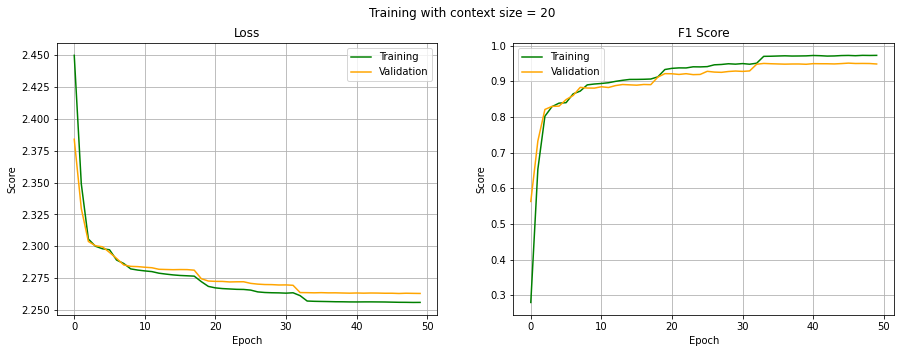

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9726, device='cuda:0'),
 tensor(0.9497, device='cuda:0'),
 tensor(0.9491, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9726, device='cuda:0'),
 tensor(0.9497, device='cuda:0'),
 tensor(0.9491, device='cuda:0'))

## Heatmap

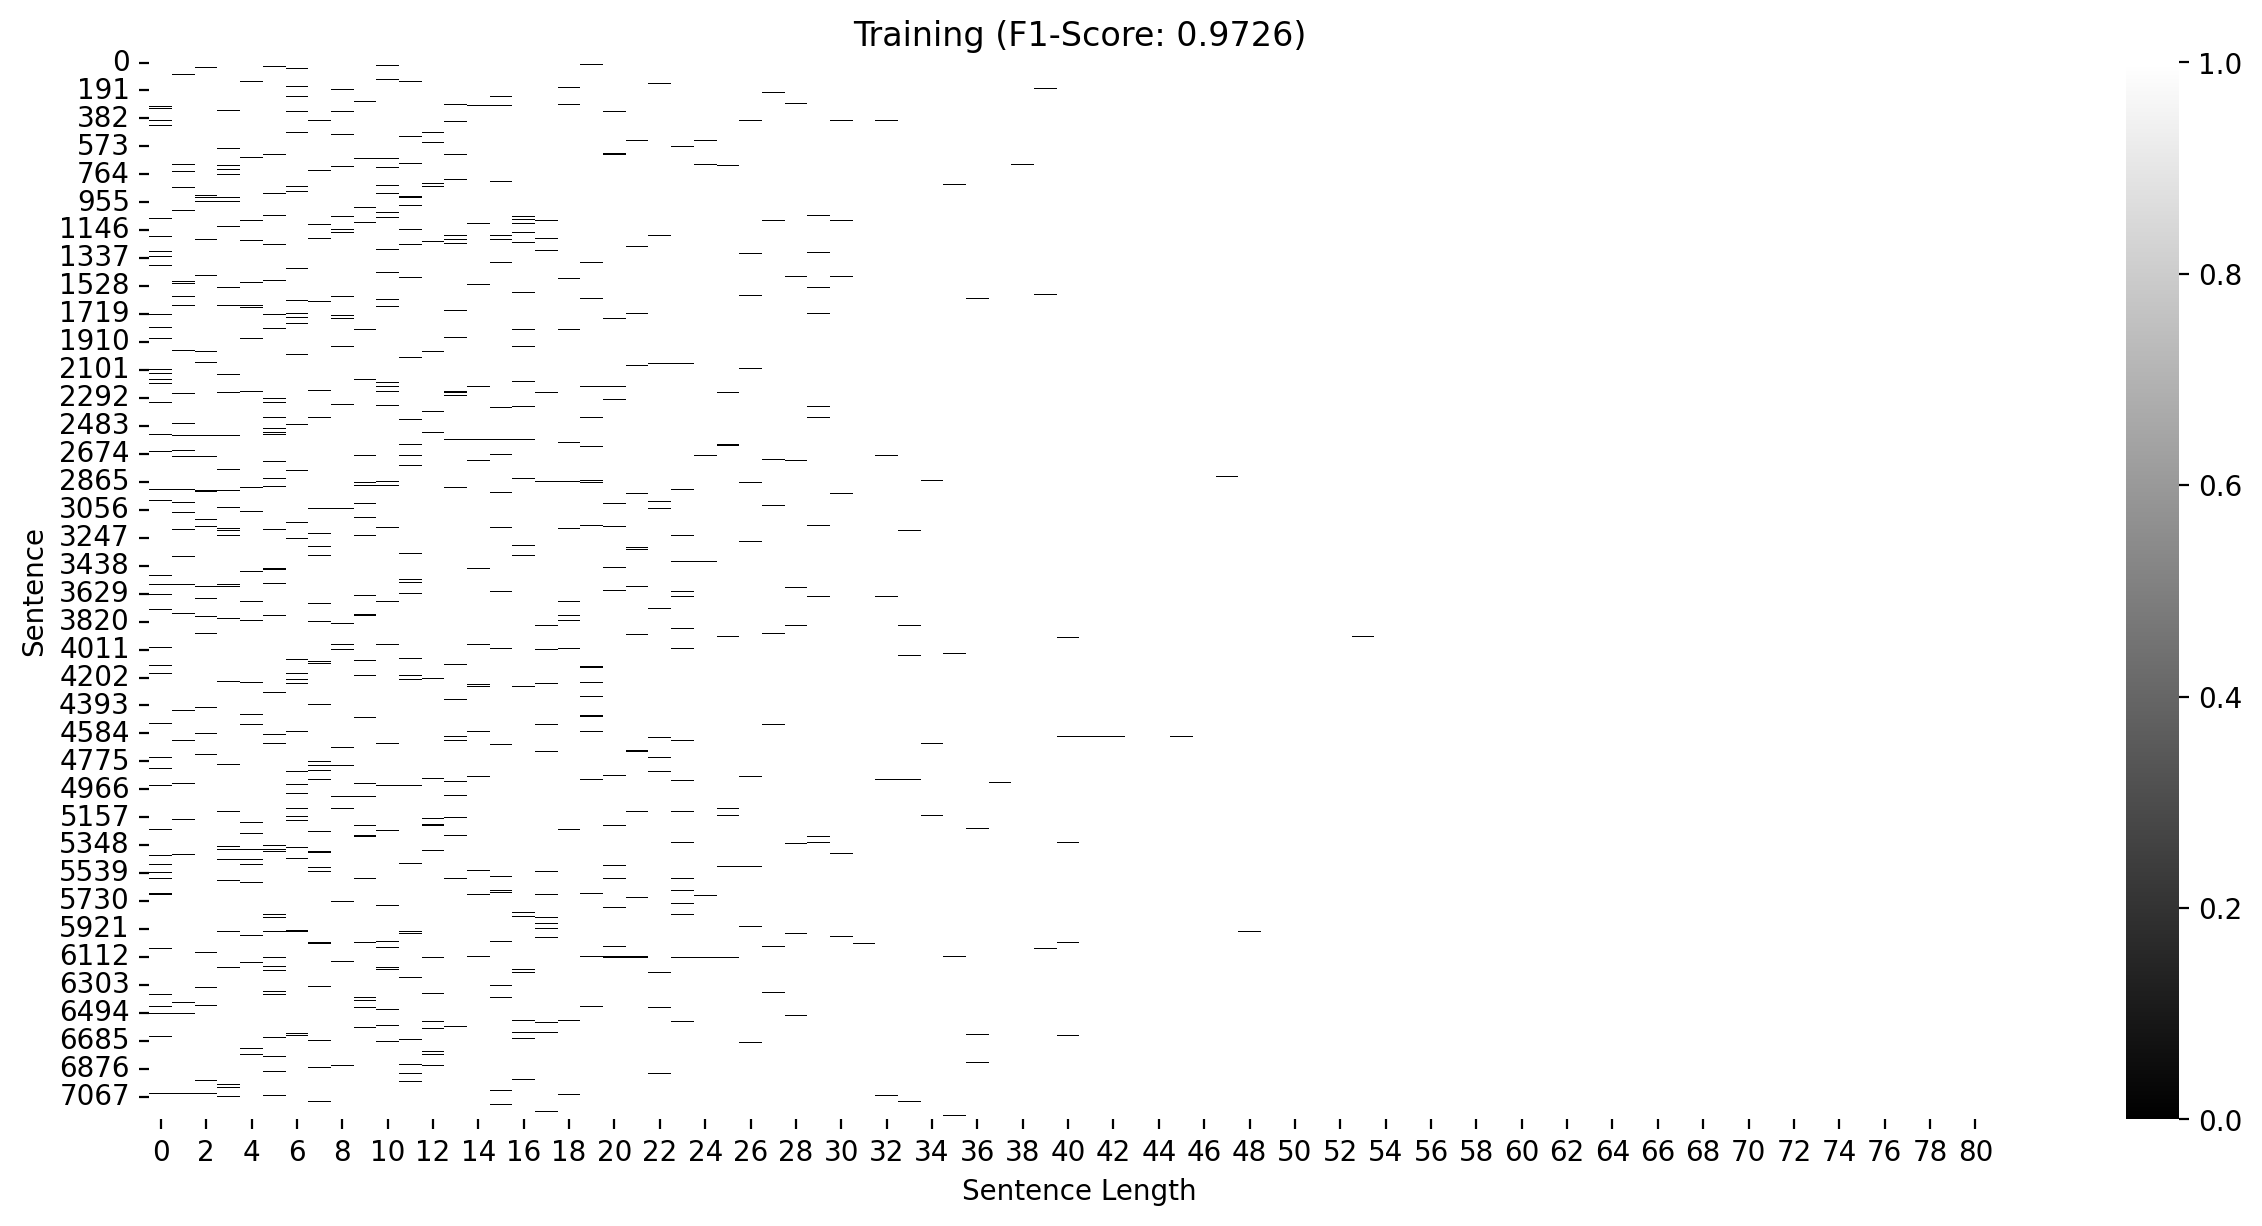

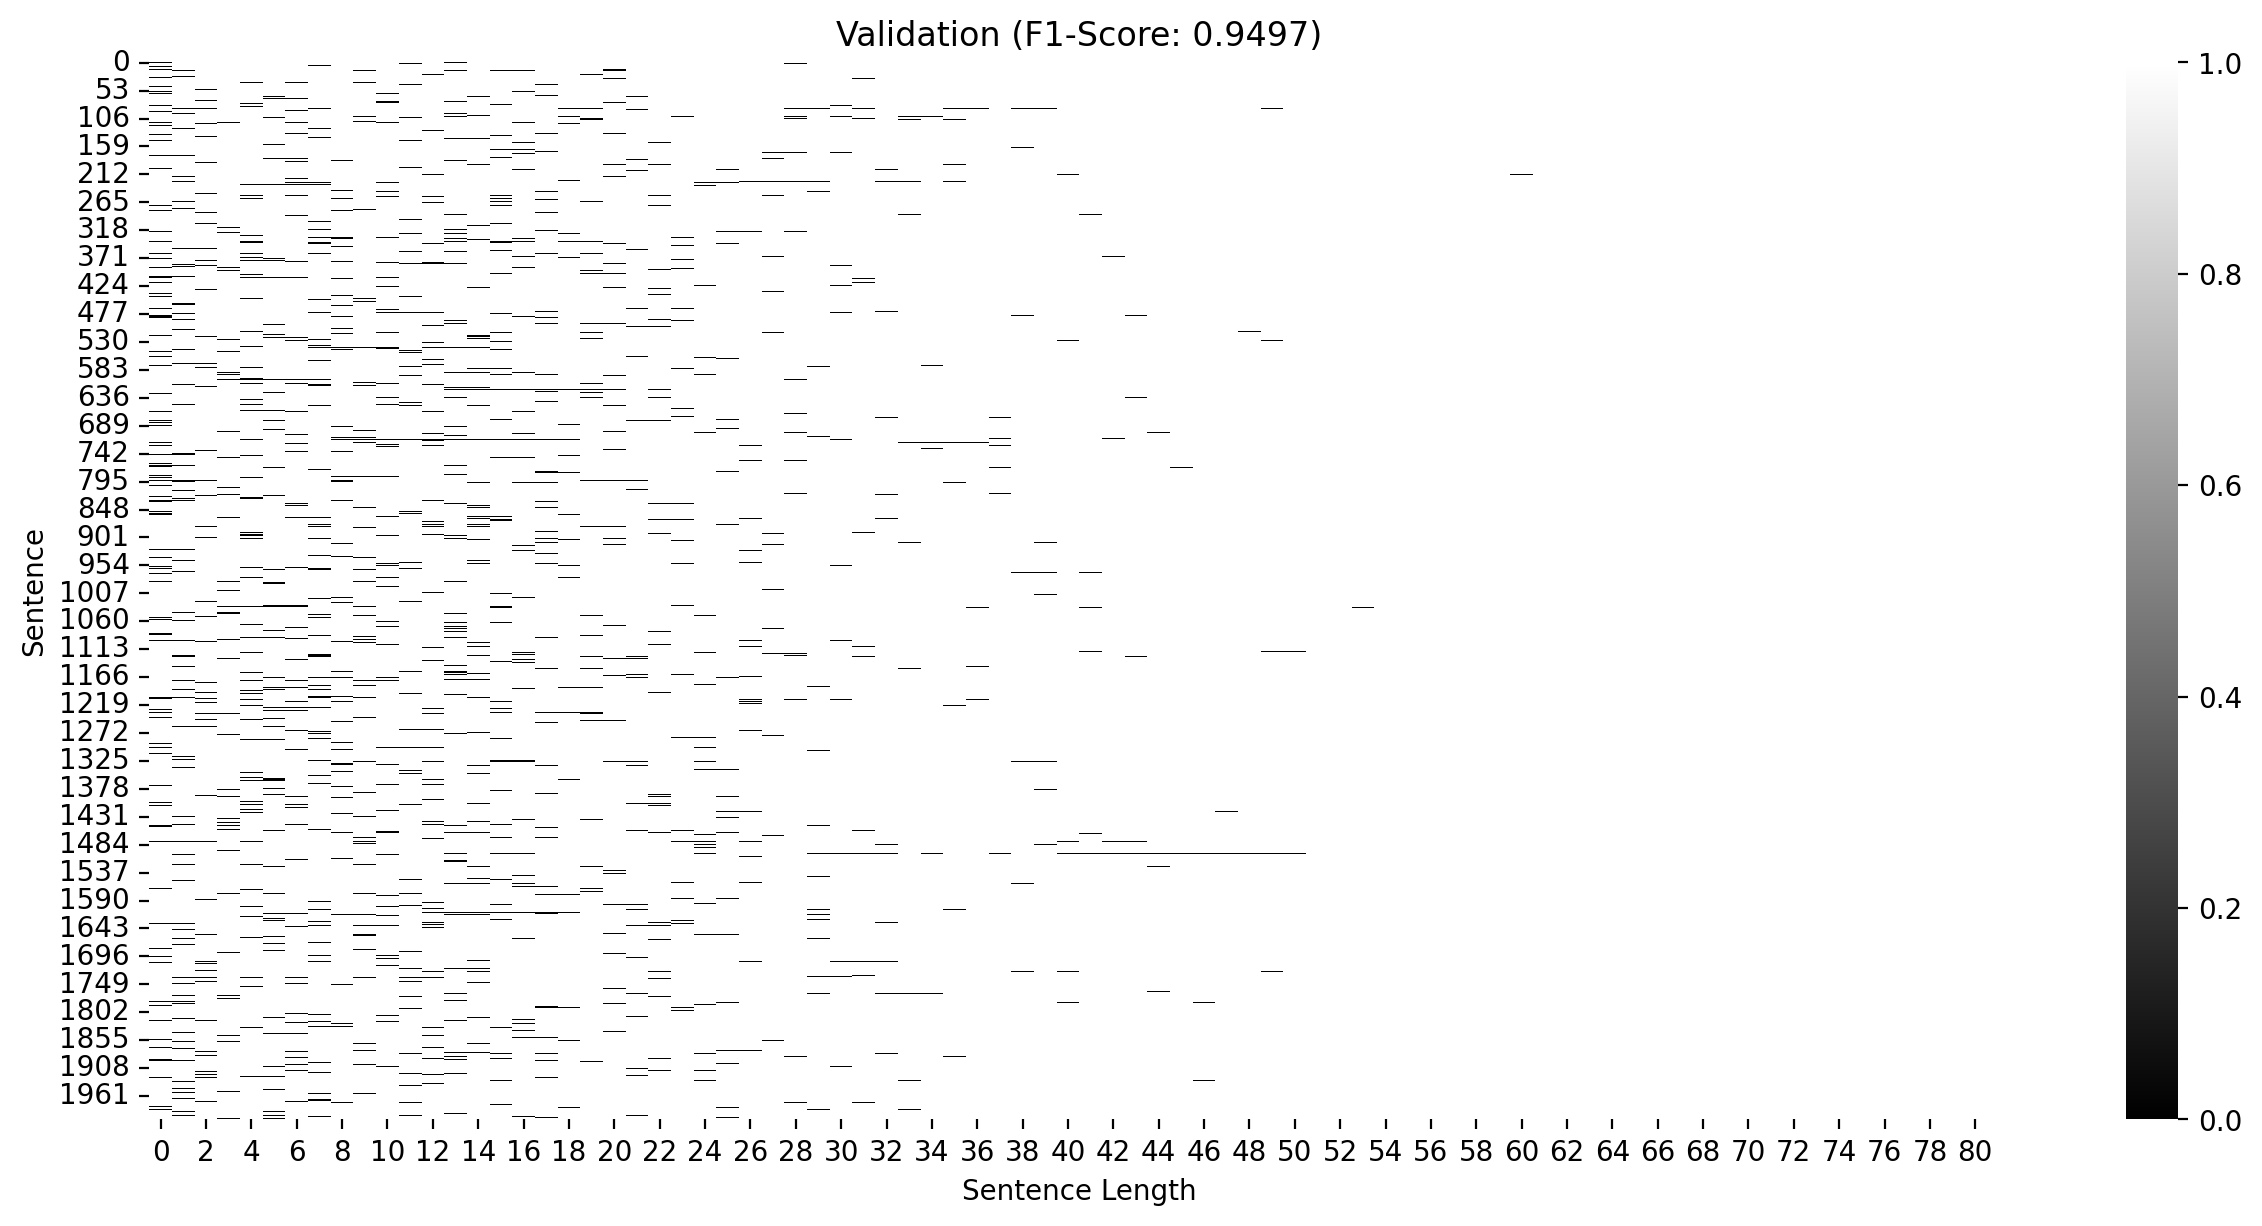

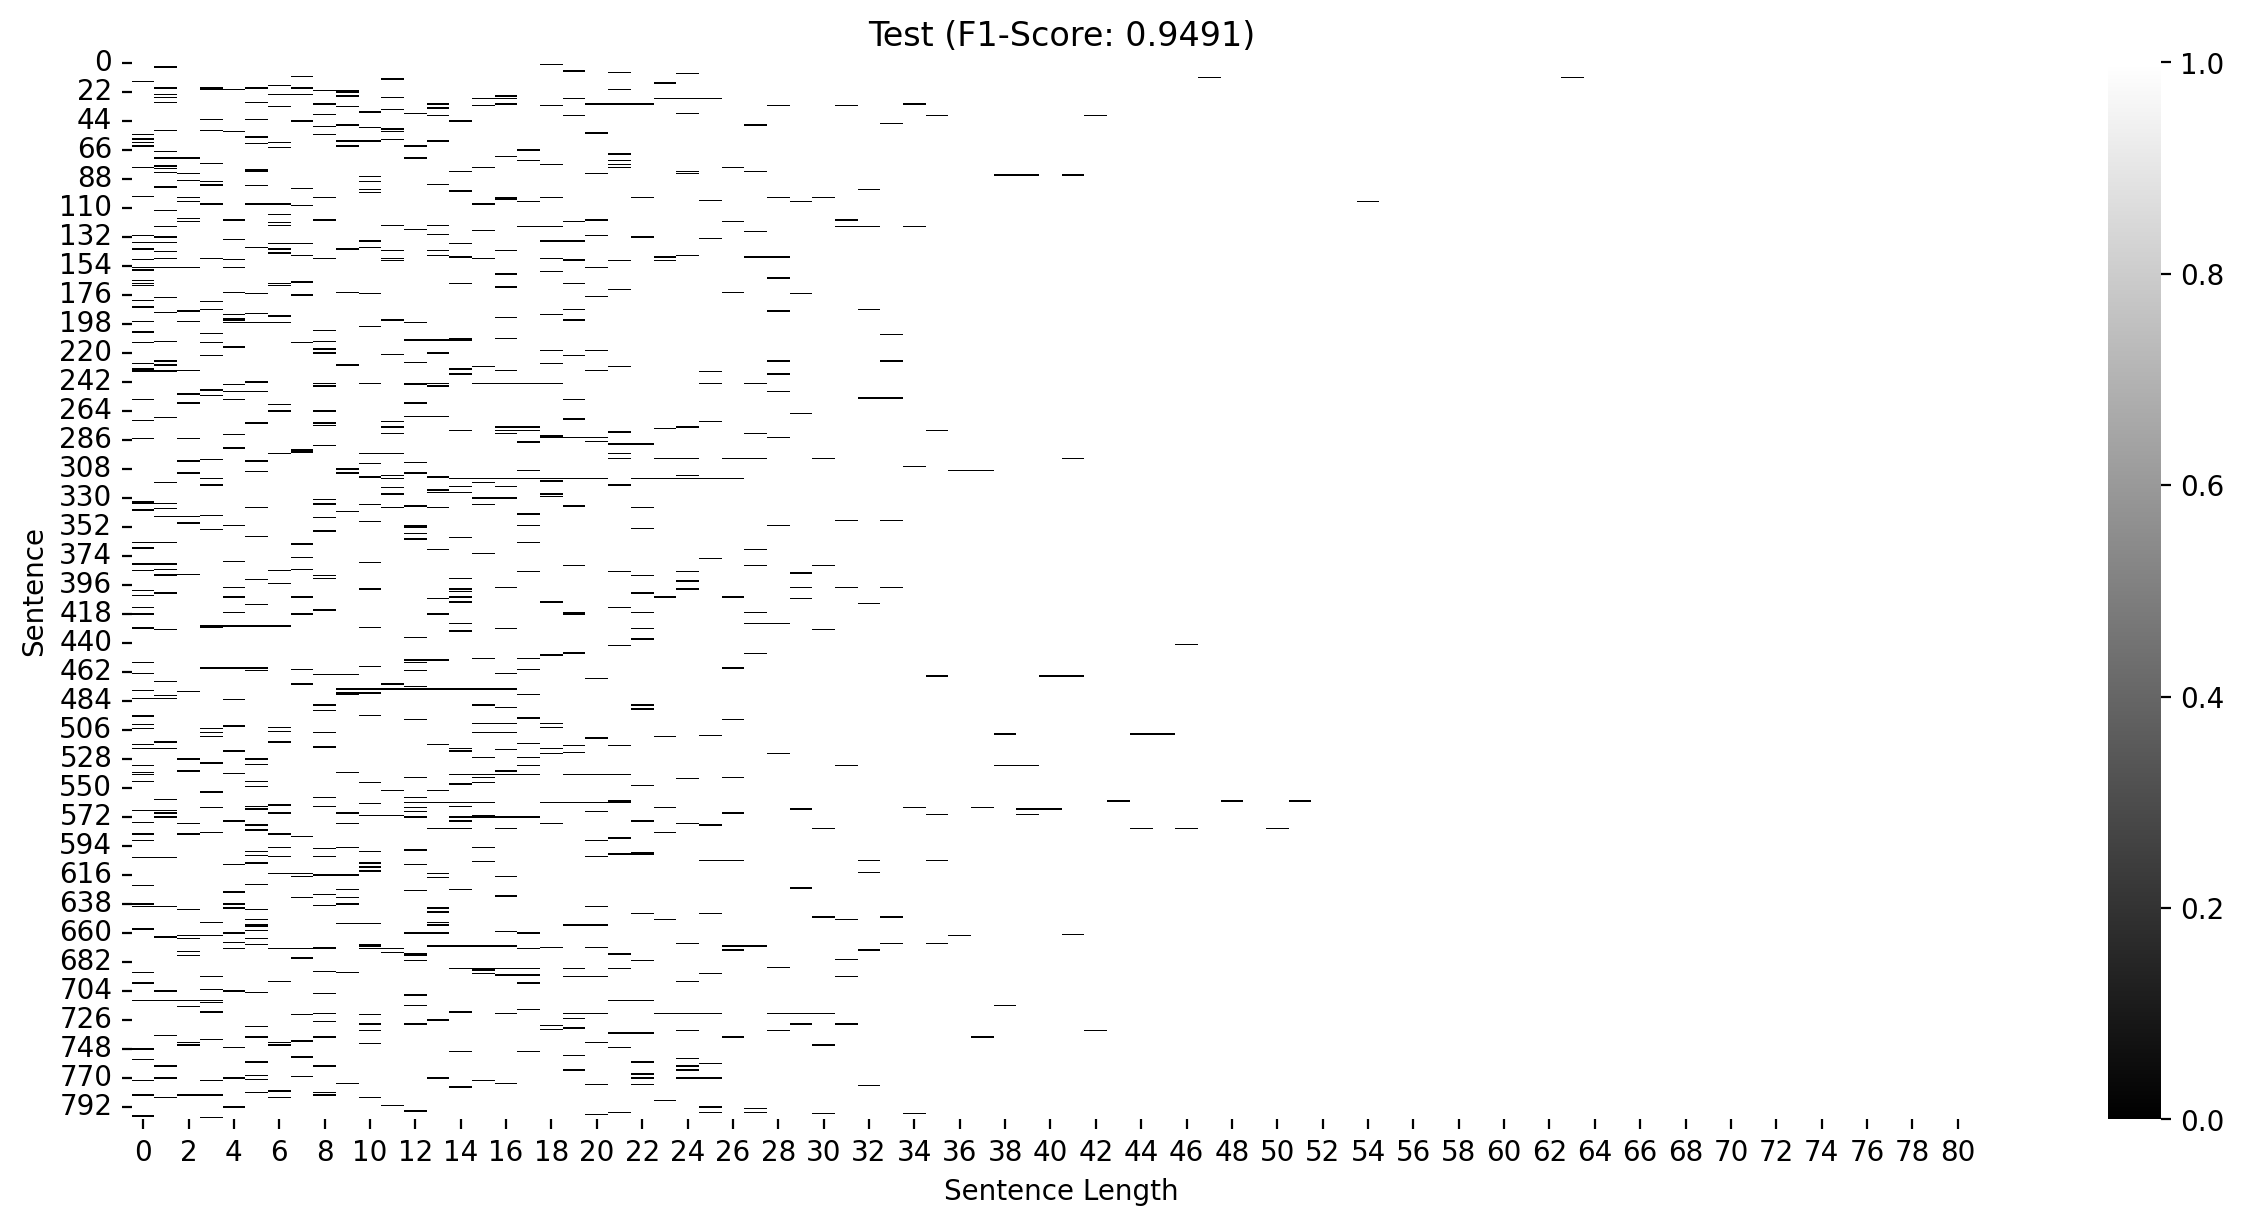

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


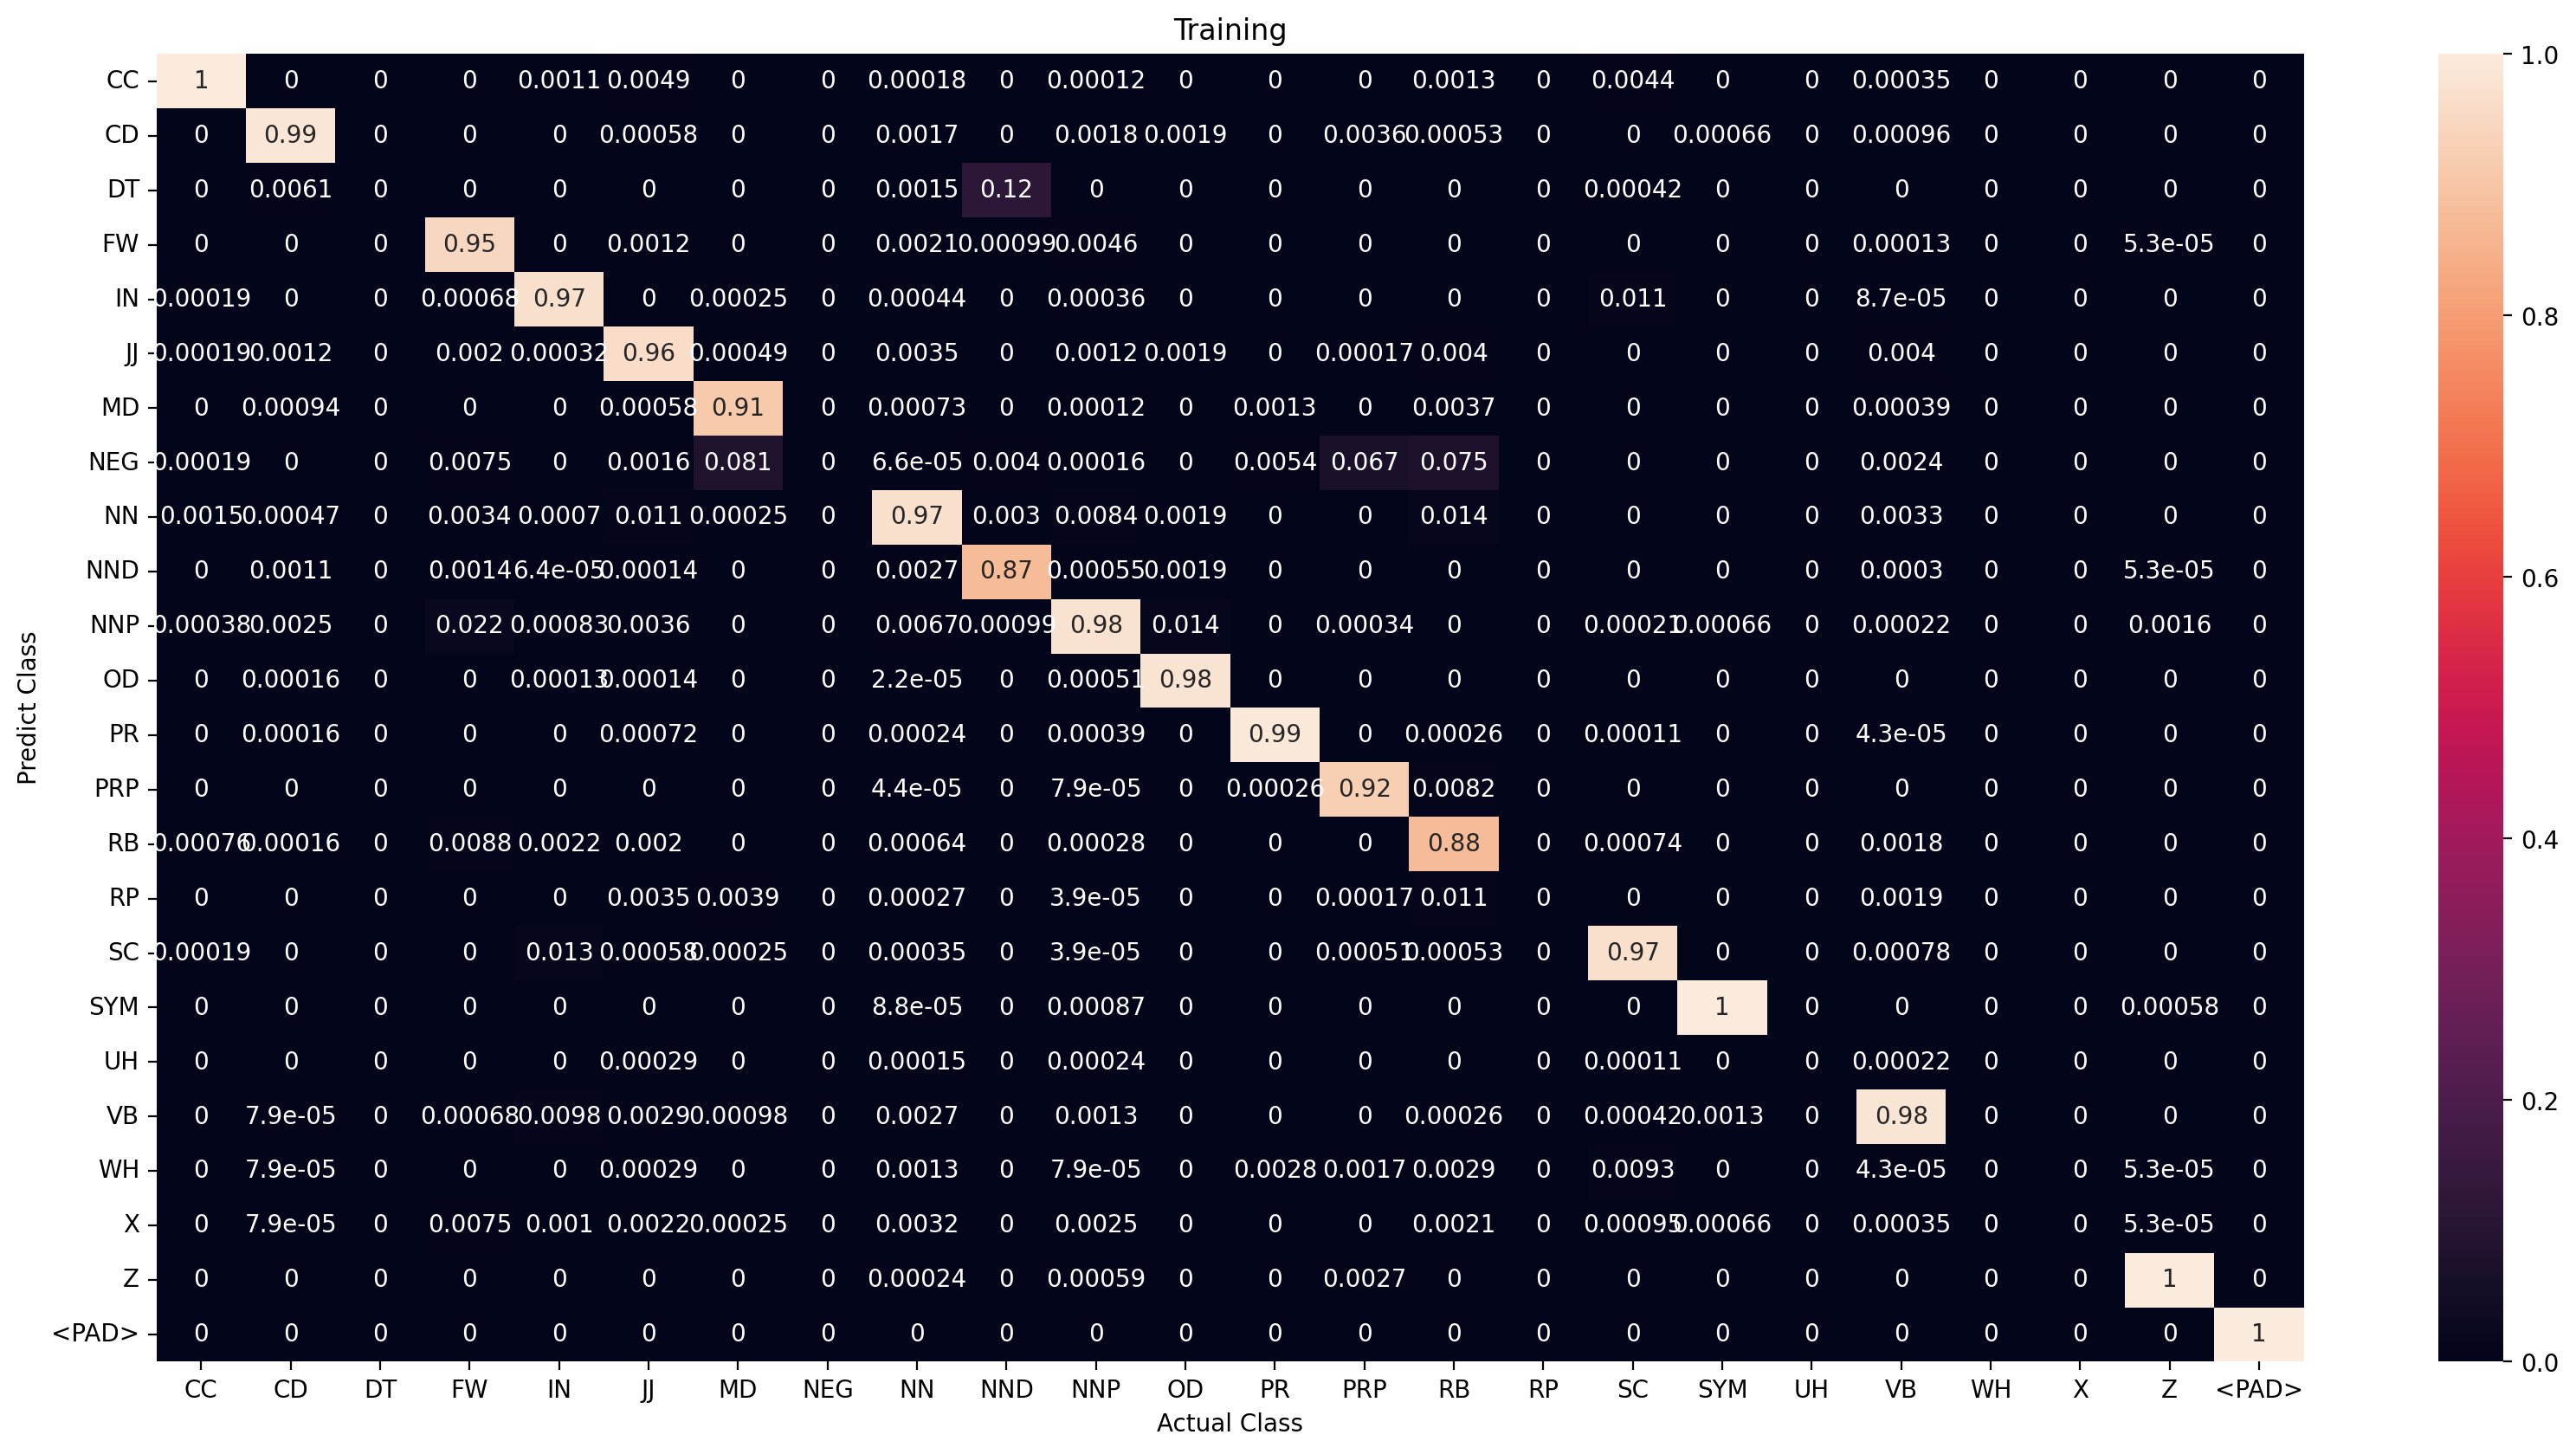

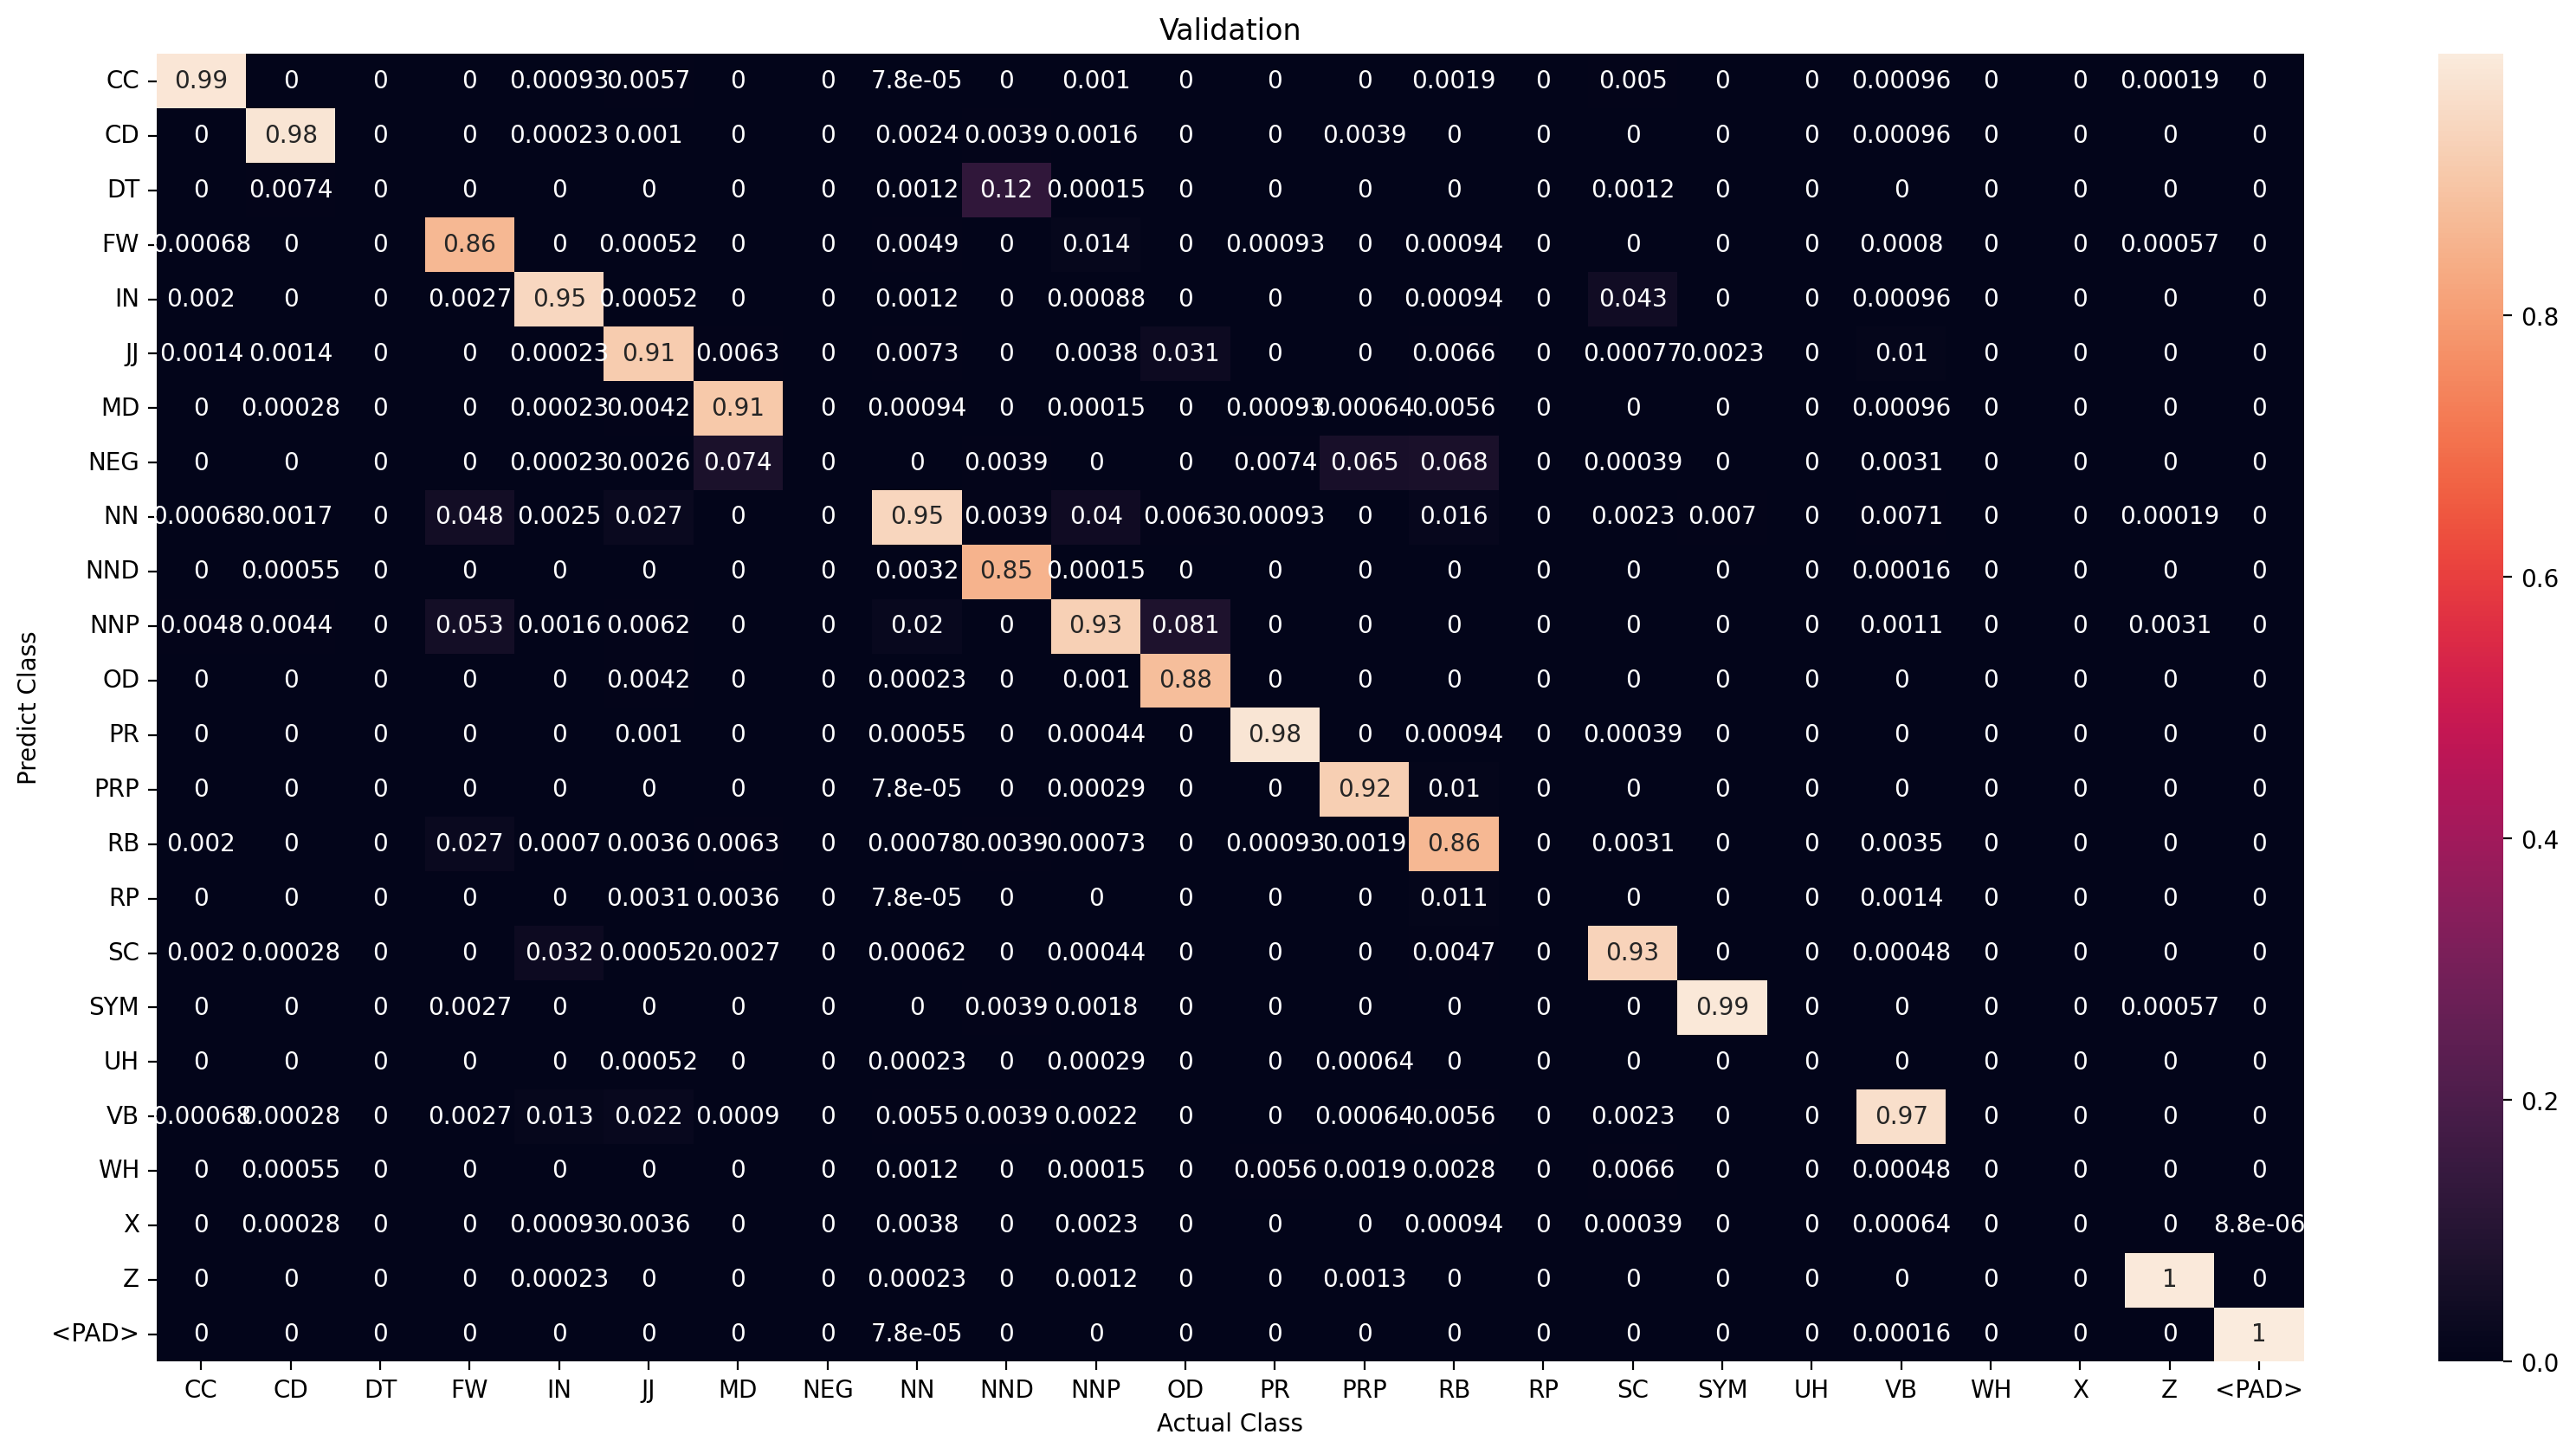

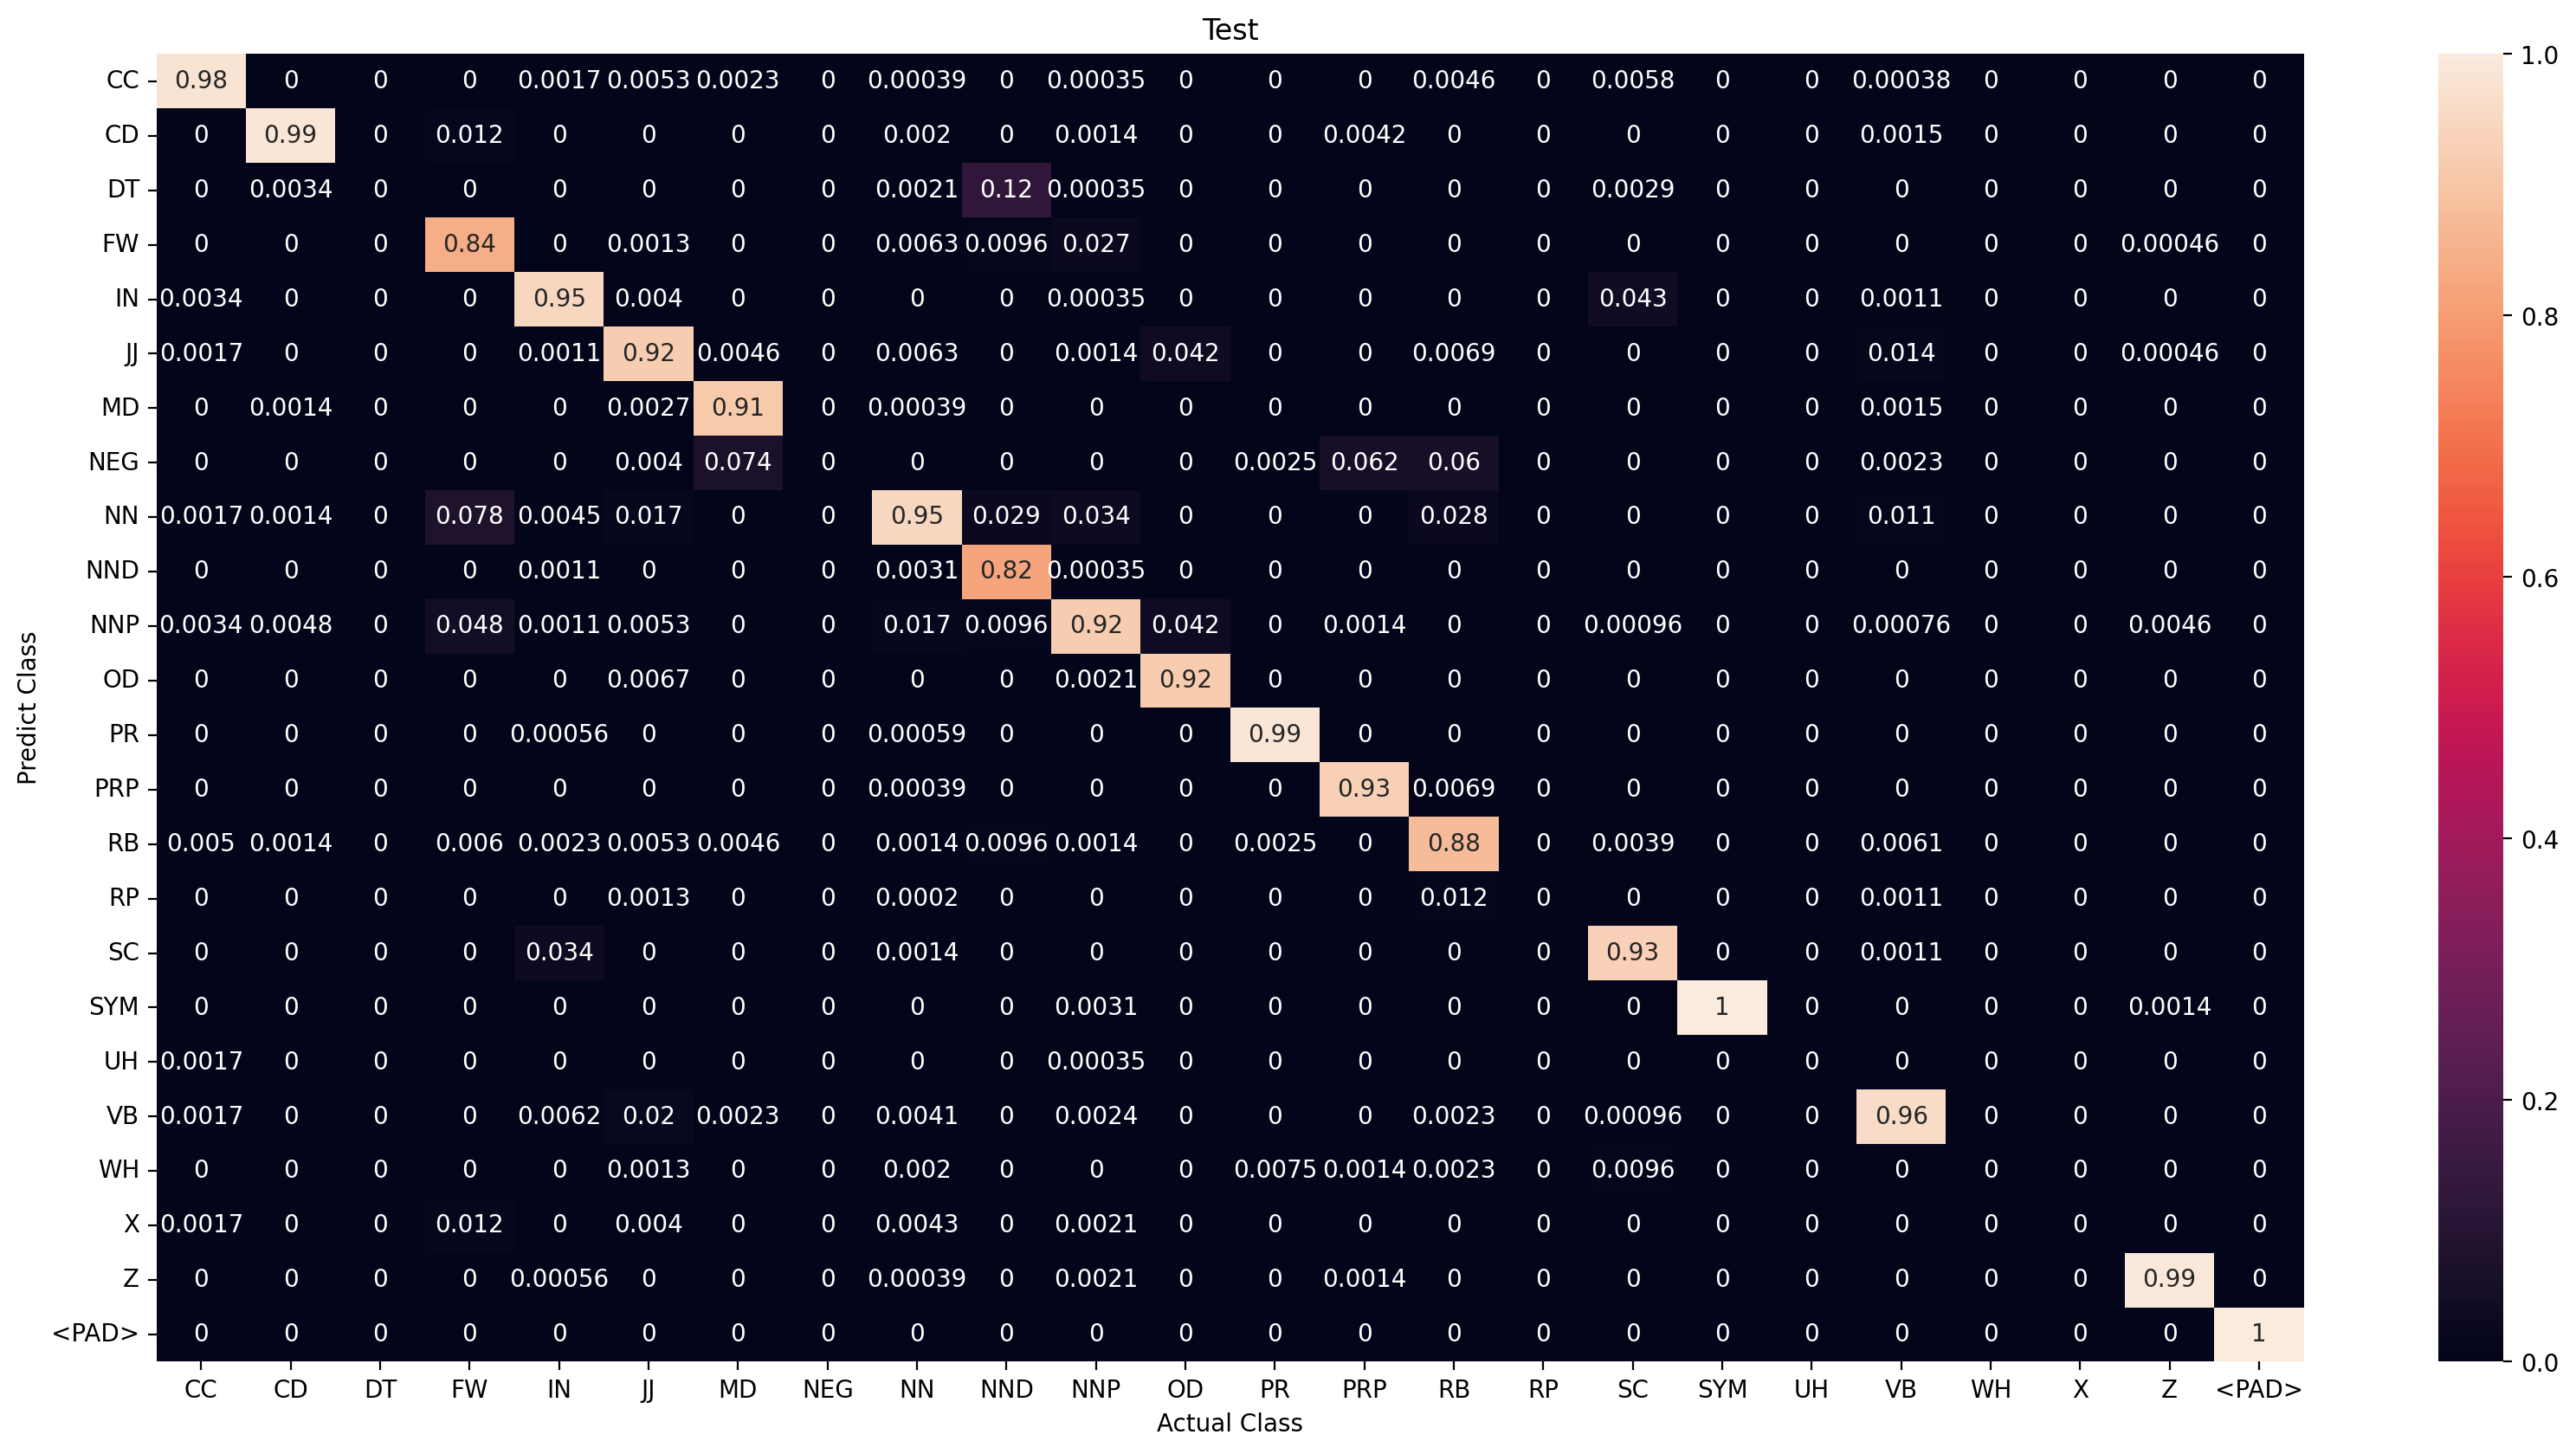

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5228       | CC    : 118      |
| CD    : 12730  | CD    : 12555      | CD    : 175      |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1389       | FW    : 225      |
| IN    : 15342  | IN    : 15203      | IN    : 139      |
| JJ    : 6981   | JJ    : 6656       | JJ    : 325      |
| MD    : 3799   | MD    : 3719       | MD    : 80       |
| NEG   : 1118   | NEG   : 0          | NEG   : 1118     |
| NN    : 44369  | NN    : 43916      | NN    : 453      |
| NND   : 1047   | NND   : 882        | NND   : 165      |
| NNP   : 25175  | NNP   : 24718      | NNP   : 457      |
| OD    : 524    | OD    : 505        | OD    : 19       |
| PR    : 3880   | PR    : 3849       | PR    : 31       |
| PRP   : 5471   | PRP   : 5435       | PRP   : 36       |
| RB    : 3477   | RB    : 3326       | RB    : 151      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 11140
Wrong prediction            : 666
Percentage correct oov pred : 94.3588006098594

Validation
Number OOV token            : 3366
Correct prediction          : 3004
Wrong prediction            : 362
Percentage correct oov pred : 89.24539512774807

Test
Number OOV token            : 1390
Correct prediction          : 1255
Wrong prediction            : 135
Percentage correct oov pred : 90.28776978417267



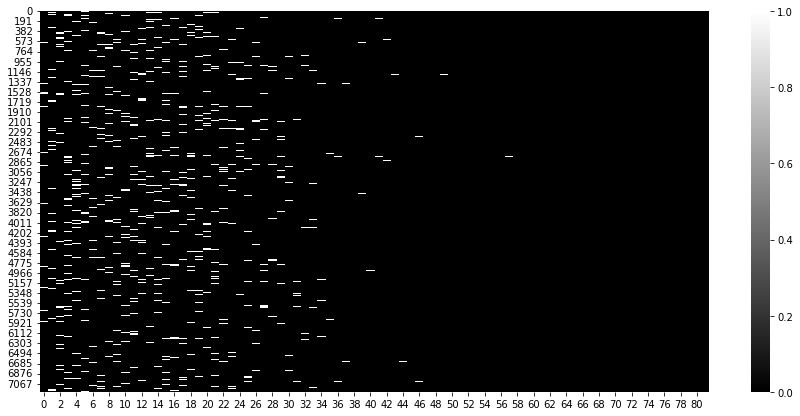

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

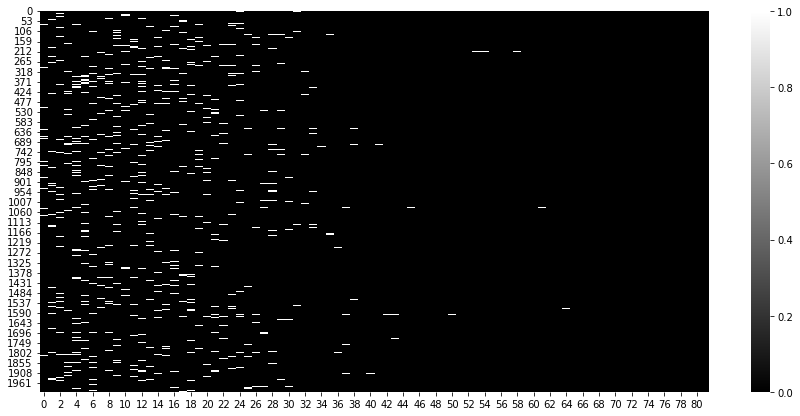

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

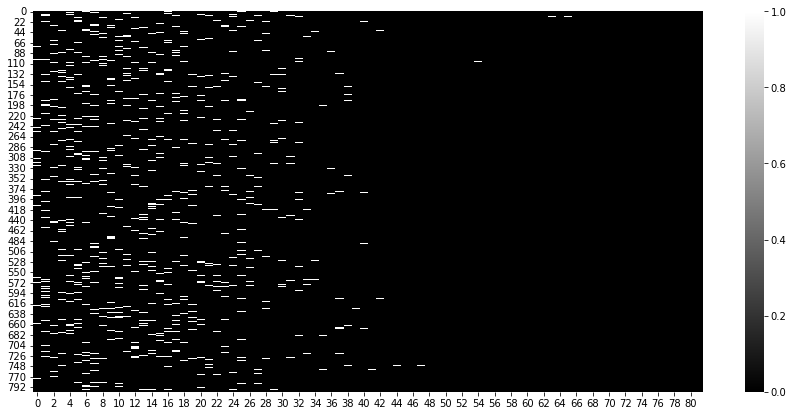

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);